# BÀI THỰC HÀNH 5: KIẾN TRÚC TRANSFORMER ENCODER

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses.

# Import libraries

In [64]:
import pandas as pd
import numpy as np
import json
import re
from underthesea import word_tokenize
import emoji
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.max_colwidth", None)

In [34]:
# Load dataset
files = ['train.json', 'dev.json', 'test.json']
fnames = ['train', 'dev', 'test']
dataset = {}

for name, file in zip(fnames, files):
    with open(f"data/UIT-ViOCD/{file}", "r", encoding="utf-8") as f:
        data = json.load(f)
    dataset[name] = pd.DataFrame(data)

train = dataset['train']
dev = dataset['dev']
test = dataset['test']

# EDA

### 1. Kiểm tra cấu trúc bộ dữ liệu

In [35]:
# Convert 
train = train.T
dev = dev.T
test = test.T

In [36]:
# Print dataset samples
print (f'Train samples: {train.shape[0]}')
print (f'Dev samples: {dev.shape[0]}')   
print (f'Test samples: {test.shape[0]}')

Train samples: 4387
Dev samples: 548
Test samples: 549


In [37]:
# Print column names
print(f'Train colummns: {train.columns}')
print(f'Dev colummns: {dev.columns}')
print(f'Test colummns: {test.columns}')

Train colummns: Index(['review', 'label', 'domain'], dtype='object')
Dev colummns: Index(['review', 'label', 'domain'], dtype='object')
Test colummns: Index(['review', 'label', 'domain'], dtype='object')


In [38]:
# Print first 5 rows of the training set
train.head(5)

,review,label,domain
0,gói hàng cẩn thận . chơi pubg với liên quân mượt với giá như này thì quá tốt,non-complaint,mobile
1,mình góp ý thật nhé . . đừng bắt phải đăng nhập zalo nữa mình muốn tải nhạc mà không được lấy lại tôi không zalo thì gửi tin nhắn mất tiền được mã kích hoạt lại không chính xác . . mình thấy 10 ngưòi thì họ khó chịu cả 10 . . lập trình viên viết ra ứng dụng ngày càng dễ sử dụng đằng này càng ngày lại càng phức tạp và . . . bài đánh giá đầy đủ,complaint,app
2,"máy khá đẹp , pin trâu vân tay nhạy nhận diện khuôn mặt nhanh nói chung ổn . tuy chơi game fre fire bị chậm khung hình không mượt lắm nhưng với giá giẫm ngày 1111 được ad mã giảm giá 200k còn hơn 2tr6 thì vậy là ngon rồi",complaint,mobile
3,"một mớ lỗi : không xem lại được bài test , không hiện link ( ví dụ như là youtube khi chia sẻ ) không copy được từ không biết để dịch . làm ơn cho về bản web đi",complaint,app
4,đặc mẫu xanh mà sao giao mẫu này vậy cửa hàng,complaint,fashion


In [39]:
# Print first 5 rows of the training set
dev.head(5)

,review,label,domain
0,quần đẹp nhưng cỡ lồn hơi ngắn,complaint,fashion
1,game hay . nhưng hy vọng admin cho thêm sự kiện lấy vàng vì mình nghĩ càng lên cấp cao thì vàng không đủ để xài . nhưng mình cho 5star,complaint,app
2,"game đầy lỗi . đội ngũ kỹ thuật kém . một ngày 1sv , một sinh viên tầm 10 người chơi là nhiều . event toàn là nạp nạp và nạp",complaint,app
3,"lừa đảo , ăn chặn tiền của khách hàng . tôi đã bị lừa một khoản tiền mặt do đổi trả hàng lởm , hàng kém chất lượng . tôi khuyên các bạn không nên mua sắm trên lazada . đã sử dụng ứng dụng này 2 năm , ngày càng thất vọng . đây là lần cuối tôi mua hàng qua ứng dụng này",complaint,app
4,"vải đẹp , mình cao 1m55 nặng 48 không mặc cỡ mình hơi ôm nhưng cũng vừa đẹp , k ôm quá , chất lượng số với giá tiền vậy là quá rẻ",non-complaint,fashion


In [40]:
# Print first 5 rows of the test set
test.head(5)

,review,label,domain
0,"dẹp xinh giá rẻ , đáng mua",non-complaint,fashion
1,cách đọc is rất god đó .,non-complaint,app
2,"tôi rất thích ứng dụng này , nó giúp cho con tôi nhận biết được mọi thứ bằng tiếng anh và các ngôn ngữ khác . xin cảm ơn .",non-complaint,app
3,"vải đẹp , giao nhanh",non-complaint,fashion
4,hàng cũng được nhưng vãi hơi mỏng,complaint,fashion


2. Phân tích phân bố nhãn (Label Distribution)

Domain distribution:
          Train  Dev  Test
domain                    
app        1613  203   194
fashion    1368  156   159
cosmetic   1043  135   150
mobile      363   54    46


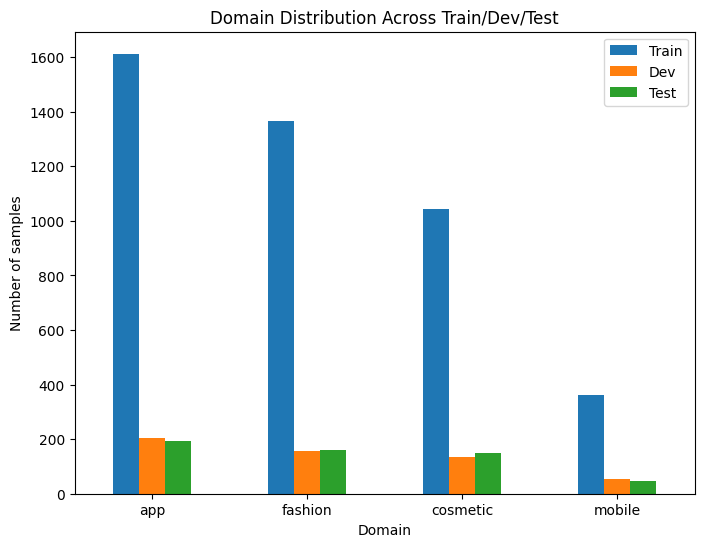

In [41]:
# Compare domain distributions across train, dev, and test sets
label_counts = pd.DataFrame({
    "Train": train['domain'].value_counts(),
    "Dev": dev['domain'].value_counts(),
    "Test": test['domain'].value_counts()
})
print(f'Domain distribution:\n{label_counts}')

# Visualize combined domain distribution
label_counts.plot(kind='bar', figsize=(8, 6))
plt.title("Domain Distribution Across Train/Dev/Test")
plt.ylabel("Number of samples")
plt.xlabel("Domain")
plt.xticks(rotation=0)
plt.show()

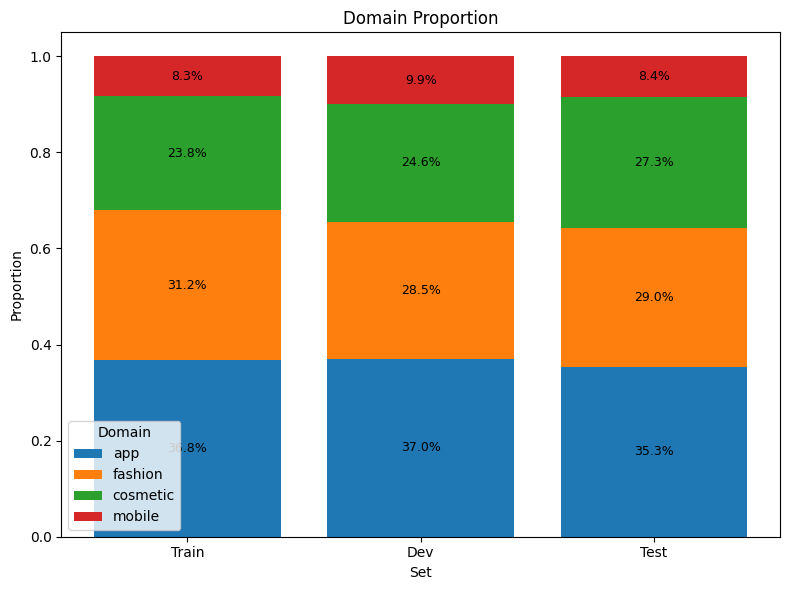

In [42]:
# Visualize domain proportions
domain_props = label_counts.div(label_counts.sum(axis=0), axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
bottom = [0] * len(domain_props.columns)

for domain, color in zip(domain_props.index, ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
    values = domain_props.loc[domain]
    bars = ax.bar(domain_props.columns, values, bottom=bottom, label=domain, color=color)
    
    for j, bar in enumerate(bars):
        h = bar.get_height()
        if h > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, bottom[j] + h/2, f"{h*100:.1f}%", 
                    ha='center', va='center', fontsize=9)
        bottom[j] += h

ax.set(title="Domain Proportion", ylabel="Proportion", xlabel="Set")
ax.set_ylim(0, 1.05)
ax.legend(title="Domain")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


* Bộ dữ liệu có sự mất cân bằng ở mức độ vừa phải giữa các lớp. Nhóm app chiếm tỷ trọng lớn nhất (khoảng 37%), trong khi nhóm mobile chiếm tỷ trọng thấp nhất (chỉ dưới 10%). Mức độ chênh lệch gấp khoảng 4 lần giữa nhóm lớn nhất và nhỏ nhất vẫn tạm chấp nhận được trong bài toán. 

* Bộ dữ liệu này  có sự phân bổ đồng đều giữa các tập Train, Dev và Test. Các tỷ lệ phần trăm của từng domain gần như không thay đổi đáng kể qua các tập, đảm bảo kết quả đánh giá mô hình sẽ khách quan và phản ánh đúng khả năng.

* Mặc dù có sự mất cân bằng nhẹ, nhưng do tính đồng nhất giữa các tập dữ liệu cao, có thể bắt đầu huấn luyện mô hình mà không cần điều chỉnh. Tuy nhiên, nếu kết quả dự đoán trên các nhóm nhỏ không tốt, các kỹ thuật như điều chỉnh trọng số hàm mất mát hoặc tăng cường dữ liệu cho nhóm thiểu số sẽ được cân nhắc áp dụng để tối ưu hóa hiệu suất.

### 3. Làm sạch dữ liệu

In [43]:
# Check missing values 
print("Missing values per column of train:\n", train.isnull().sum())
print("Missing values per column of dev:\n", dev.isnull().sum())
print("Missing values per column of test:\n", test.isnull().sum())

Missing values per column of train:
 review    0
label     0
domain    0
dtype: int64
Missing values per column of dev:
 review    0
label     0
domain    0
dtype: int64
Missing values per column of test:
 review    0
label     0
domain    0
dtype: int64


In [44]:
# Check duplicate
print("Duplicate samples of train:", train.duplicated().sum())
print("Duplicate samples of dev:", dev.duplicated().sum())
print("Duplicate samples of test:", test.duplicated().sum())

Duplicate samples of train: 139
Duplicate samples of dev: 0
Duplicate samples of test: 3


In [45]:
# Remove duplicate
train = train.drop_duplicates()
dev = dev.drop_duplicates()
test = test.drop_duplicates()

print("Train shape:\n", train.shape)
print("Dev shape:\n", dev.shape)
print("Test shape:\n", test.shape)

Train shape:
 (4248, 3)
Dev shape:
 (548, 3)
Test shape:
 (546, 3)


### 4. Phân tích độ dài câu

In [46]:
# Count token/word in each review
train_lengths = train['review'].apply(lambda x: len(x.split()))
dev_lengths = dev['review'].apply(lambda x: len(x.split()))
test_lengths = test['review'].apply(lambda x: len(x.split()))

# Print review length statistics
print(f'Train review lengths:\n{train_lengths.describe()}\n')
print(f'Dev review lengths:\n{dev_lengths.describe()}\n')
print(f'Test review lengths:\n{test_lengths.describe()}\n')

Train review lengths:
count    4248.000000
mean       32.325565
std        28.661190
min         1.000000
25%         9.000000
50%        21.000000
75%        51.000000
max       256.000000
Name: review, dtype: float64

Dev review lengths:
count    548.000000
mean      32.562044
std       27.960238
min        1.000000
25%        9.000000
50%       22.000000
75%       55.250000
max       95.000000
Name: review, dtype: float64

Test review lengths:
count    546.000000
mean      32.034799
std       29.642715
min        1.000000
25%        9.000000
50%       21.500000
75%       48.750000
max      293.000000
Name: review, dtype: float64



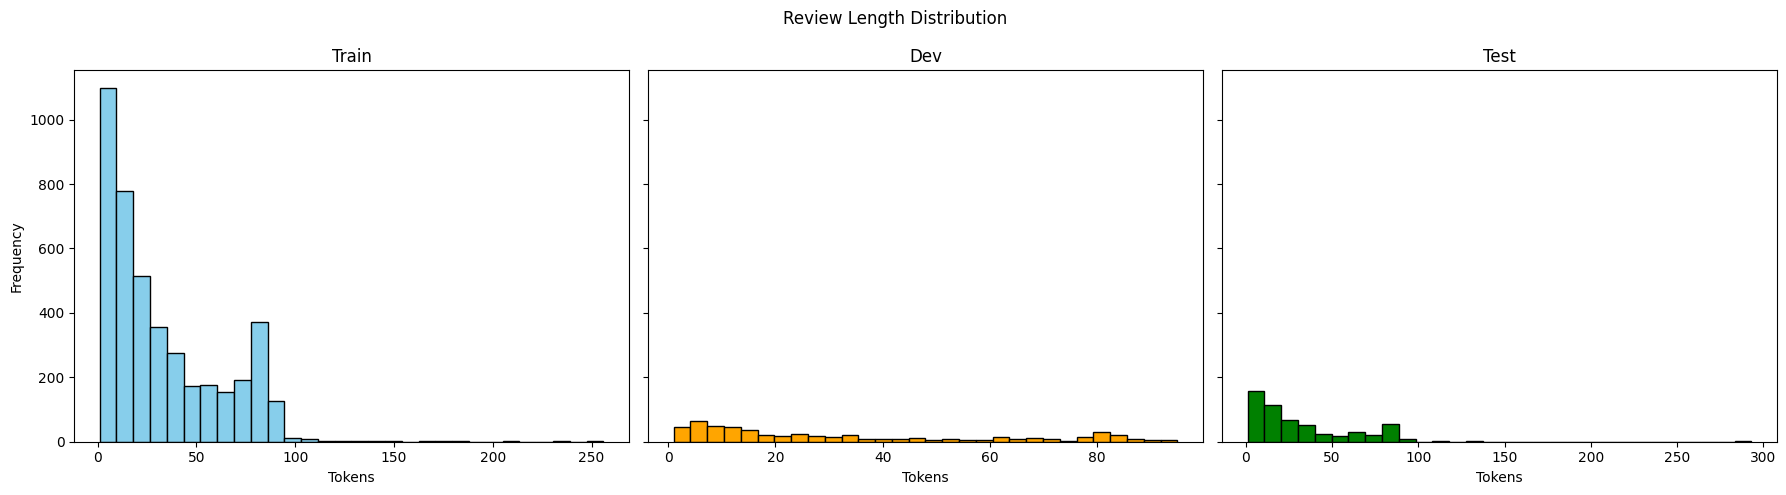

In [47]:
# Plot review length distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Train
axes[0].hist(train_lengths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Train")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Frequency")

# Dev
axes[1].hist(dev_lengths, bins=30, color='orange', edgecolor='black')
axes[1].set_title("Dev")
axes[1].set_xlabel("Tokens")

# Test
axes[2].hist(test_lengths, bins=30, color='green', edgecolor='black')
axes[2].set_title("Test")
axes[2].set_xlabel("Tokens")

plt.suptitle("Review Length Distribution")
plt.tight_layout()
plt.show()


In [48]:
optimal_pad = int(np.percentile(train_lengths, 98))
print("Padding (98%):", optimal_pad)

Padding (98%): 88


* Tập Train: Phân phối lệch phải, tập trung ở khoảng 0-50 tokens. Tuy nhiên, dữ liệu có sự tăng nhẹ ở khoảng 80-90 tokens, cho thấy có một nhóm người dùng nhất định thường viết các đánh giá với độ dài trung bình khá ổn định ở ngưỡng này.

* Tập Dev: Có hình dạng phân phối tương đồng với tập Train nhưng quy mô nhỏ hơn nhiều, với tần suất cao nhất chỉ dưới 100 mẫu. Các đánh giá chủ yếu vẫn nằm trong khoảng dưới 40 tokens.

* Tập Test: Phân phối lệch phải, quy mô giống tập dev, nhưng có sự xuất hiện rõ rệt hơn của các giá trị ngoại lệ (outliers) ở phía đuôi. Một số ít mẫu có độ dài vượt xa mức trung bình, lên đến gần 300 tokens.

-> Cả ba tập dữ liệu đều có phân phối lệch phải, các đánh giá ngắn chiếm đa số. Có thể chọn max_sequence_length = 88 để bao phủ >98% câu ở cả 3 tập và giữ thêm thông tin cho các câu dài. 

### 5. Thống kê từ vựng

In [49]:
# Unique token
def unique_tokens(dataset):
    token_counter = Counter()
    for review in dataset:
        tokens = review.split()
        token_counter.update(tokens)
    return token_counter

train_token_counts = unique_tokens(train['review'])
dev_token_counts = unique_tokens(dev['review'])
test_token_counts = unique_tokens(test['review'])

In [50]:
# Count unique tokens in each dataset
print(f'Number of unique tokens in the train set: {len(train_token_counts)}')
print(f'Number of unique tokens in the dev set: {len(dev_token_counts)}')
print(f'Number of unique tokens in the test set: {len(test_token_counts)}')

Number of unique tokens in the train set: 4629
Number of unique tokens in the dev set: 1839
Number of unique tokens in the test set: 1904


In [51]:
# Display the most 20 tokens
print(f'Most common tokens in Train set:\n{train_token_counts.most_common(20)}')
print(f'Most common tokens in Dev set:\n{dev_token_counts.most_common(20)}')
print(f'Most common tokens in Test set:\n{test_token_counts.most_common(20)}')

Most common tokens in Train set:
[('.', 7041), (',', 4001), ('không', 2740), ('hàng', 2197), ('có', 1798), ('được', 1794), ('rất', 1503), ('thì', 1302), ('mình', 1230), ('tôi', 1160), ('là', 1122), ('nhưng', 1085), ('lại', 1068), ('và', 1053), ('game', 954), ('cho', 934), ('mà', 925), ('giá', 908), ('một', 875), ('giao', 847)]
Most common tokens in Dev set:
[('.', 960), (',', 521), ('không', 360), ('hàng', 300), ('có', 253), ('được', 217), ('rất', 204), ('mình', 175), ('thì', 170), ('nhưng', 146), ('và', 145), ('lại', 143), ('là', 135), ('mà', 130), ('tôi', 129), ('giá', 120), ('cho', 115), ('giao', 113), ('game', 112), ('người', 108)]
Most common tokens in Test set:
[('.', 897), (',', 464), ('không', 351), ('hàng', 264), ('có', 232), ('được', 212), ('rất', 209), ('thì', 175), ('tôi', 164), ('mình', 161), ('nhưng', 147), ('và', 138), ('cho', 130), ('mà', 127), ('là', 127), ('người', 112), ('game', 111), ('lại', 110), ('giá', 10

Dữ liệu nên được tiền xử lý trước khi huấn luyện mô hình: 

* Lowercase giúp giảm số lượng từ vựng trùng lặp do viết hoa/viết thường.

* Remove punctuation để loại bỏ dấu câu như ".", "," không mang nhiều ý nghĩa trong mô hình.

* Fix Unicode nếu dữ liệu có lỗi mã hóa (ký tự lạ, dấu sai…).

-> Tiền xử lý dữ liệu văn bản là bước quan trọng giúp làm sạch, chuẩn hóa dữ liệu, giúp giảm số lượng từ vựng trùng lặp, tăng độ nhất quán, và loại bỏ nhiễu không cần thiết. Nhờ đó, mô hình học hiệu quả hơn, tốc độ huấn luyện nhanh hơn, và kết quả phân tích chính xác hơn.

### 6. Tiền xử lí

In [52]:
# Load Vietnamese stopwords
with open("vietnamese-stopwords.txt", "r", encoding="utf-8") as f:
    VIETNAMESE_STOPWORDS = set(f.read().splitlines())

# Preprocess Vietnamese text
def preprocess_vietnamese(text):
    text = unicodedata.normalize('NFC', text)
    text = text.lower()
    text = emoji.demojize(text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text, format="fixed")
    tokens = [tok for tok in tokens if tok not in VIETNAMESE_STOPWORDS and len(tok) > 1]
    result = " ".join(tokens)
    return result

In [53]:
# Get 5 random sample reviews from the training set
sample_reviews = train['review'].sample(5, random_state=42)

# Preprocess and display results
for sample in sample_reviews:
    processed = preprocess_vietnamese(sample)
    print("Before:", sample, "-> After :", processed)

Before: lazada có rẻ hơn sendo nhưng thực tế làm ăn thiếu tôn trọng khách hàng , không đặt hàng xong có mã đơn hàng sau đó tự ý huỷ , , nếu đã đứng ra làm trung quốc gian ăn tiền giao hàng thì phải có trách nhiệm gọi cho khách và báo hết hàng hoặc lý lo huỷ đơn hàng , đằng này khách đợi cho chán vào kiểm tra thấy bị huỷ , l . . . bài đánh giá đầy đủ -> After : lazada rẻ sendo làm ăn tôn trọng khách hàng đặt hàng xong mã đơn hàng hủy đứng trung quốc gian ăn tiền giao hàng trách nhiệm gọi báo hàng lý lo hủy đơn hàng đằng đợi chán kiểm tra hủy đầy đủ
Before: dịch sai từ rất nhiều -> After : dịch sai
Before: giao hạn sử dụng cũ sản xuất tận một năm trc . có mùi không thơm như sử dụng trước đó . mùi kì kì . mong cửa hàng phản hồi -> After : giao hạn cũ sản xuất tận trc mùi thơm mùi kì kì mong cửa hàng phản hồi
Before: tạm được với giá tiên -> After : tạm giá tiên


In [54]:
train['processed_review'] = train['review'].apply(preprocess_vietnamese)
dev['processed_review'] = dev['review'].apply(preprocess_vietnamese)
test['processed_review'] = test['review'].apply(preprocess_vietnamese)

### Bài 1: Xây dựng mô hình Transformer Encoder gồm 3 lớp theo mô tả trong nghiên cứu [Attention is all you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Huấn luyện mô hình này cho bài toán phân loại domain câu bình luận trên bộ dữ liệu [UIT-ViOCD](https://drive.google.com/drive/folders/1Lu9axyLkw7dMx80uLRgvCnZsmNzhJWAa?usp=sharing).

In [55]:
import torch.nn as nn
import torch
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['domain'])
y_dev = label_encoder.transform(dev['domain'])
y_test = label_encoder.transform(test['domain'])

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train['review'])

# Prepare sequences
def prepare_sequence(texts, max_len=88):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len, padding='post')

# Prepare data
X_train = prepare_sequence(train['review'])
X_dev = prepare_sequence(dev['review'])
X_test = prepare_sequence(test['review'])

# Create Dataset
class ViOCDDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label

 # Create DataLoaders   
train_loader = DataLoader(ViOCDDataset(X_train, y_train), batch_size=32, shuffle=True)
dev_loader = DataLoader(ViOCDDataset(X_dev, y_dev), batch_size=32, shuffle=False)
test_loader = DataLoader(ViOCDDataset(X_test, y_test), batch_size=32, shuffle=False)

In [57]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3, num_classes=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        x = self.embedding(x) * math.sqrt(256)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.fc(x)

In [ ]:
# Early Stopping after 3 epoch not get better loss
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} to {val_loss:.6f}).  Saving model.')
        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss

In [59]:
def evaluate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    avg_loss = val_loss / len(loader)
    accuracy = (correct / total)
    
    return avg_loss, accuracy, all_labels, all_preds

In [61]:
# Initialize Early Stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(vocab_size=10000, num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
for epoch in range(20):
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_samples = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch")
    for texts, labels in pbar:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        train_correct += (pred == labels).sum().item()
        train_samples += labels.size(0)
        
        pbar.set_postfix(loss=f"{total_train_loss/(pbar.n+1):.4f}", acc=f"{train_correct/train_samples:.2f}")

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = (train_correct / train_samples)
    
    # Validation
    val_loss, val_acc, _, _ = evaluate(model, dev_loader, criterion, device)
    
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Check Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

Epoch 1: 100%|██████████| 133/133 [01:54<00:00,  1.16batch/s, acc=0.76, loss=0.6338]


Val Loss: 0.3594 | Val Acc: 0.86%
Validation loss decreased (inf to 0.359447).  Saving model.


Epoch 2: 100%|██████████| 133/133 [01:16<00:00,  1.74batch/s, acc=0.86, loss=0.3860]


Val Loss: 0.3726 | Val Acc: 0.87%
EarlyStopping counter: 1 out of 3


Epoch 3: 100%|██████████| 133/133 [01:10<00:00,  1.88batch/s, acc=0.88, loss=0.3434]


Val Loss: 0.3326 | Val Acc: 0.87%
Validation loss decreased (0.359447 to 0.332611).  Saving model.


Epoch 4: 100%|██████████| 133/133 [01:10<00:00,  1.89batch/s, acc=0.88, loss=0.3227]


Val Loss: 0.4563 | Val Acc: 0.83%
EarlyStopping counter: 1 out of 3


Epoch 5: 100%|██████████| 133/133 [01:18<00:00,  1.70batch/s, acc=0.89, loss=0.3105]


Val Loss: 0.4045 | Val Acc: 0.84%
EarlyStopping counter: 2 out of 3


Epoch 6: 100%|██████████| 133/133 [01:28<00:00,  1.50batch/s, acc=0.89, loss=0.2980]


Val Loss: 0.4185 | Val Acc: 0.84%
EarlyStopping counter: 3 out of 3


<All keys matched successfully>

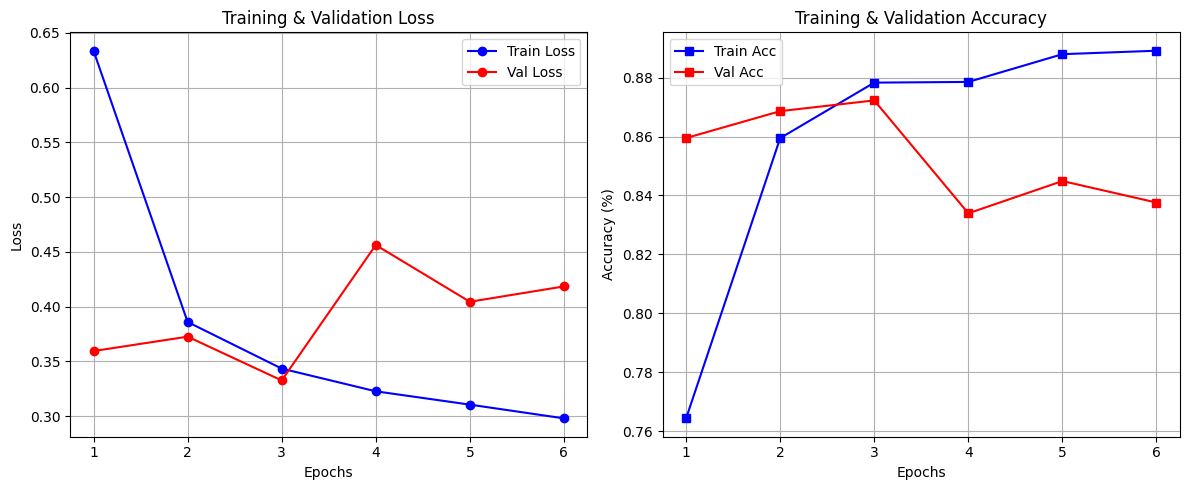

In [62]:
def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-s', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-s', label='Val Acc')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training results
plot_training_results(history)

* Early Stopping đã dừng quá trình huấn luyện ở epoch 6, để tiết kiệm tài nguyên.

* Train Loss giảm rất đều từ khoảng 0.63 xuống còn 0.30 sau 6 epoch, chứng tỏ mô hình đang học rất tốt các đặc trưng của tập dữ liệu huấn luyện. Val Loss gGiảm trong 3 epoch đầu tiên, tuy nhiên từ epoch 4 trở đi, Val Loss bắt đầu có xu hướng tăng dần. Khoảng cách giữa Train Loss và Val Loss rộng ra hơn sau epoch 3 là dấu hiệu sớm của Overfitting.

* Train Acc tăng mạnh, đạt gần 0.89 ở epoch 6. Val Acc cao nhất tại epoch 3 (0.87). Sau đó, độ chính xác trên tập val/dev giảm mạnh từ epoch 4.

In [68]:
# Evaluate
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}")

# Print detailed classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Test Loss: 0.4189
Test Accuracy: 0.89
              precision    recall  f1-score   support

         app       0.95      0.96      0.95       194
    cosmetic       0.90      0.81      0.85       149
     fashion       0.84      0.93      0.88       157
      mobile       0.79      0.72      0.75        46

    accuracy                           0.89       546
   macro avg       0.87      0.85      0.86       546
weighted avg       0.89      0.89      0.89       546



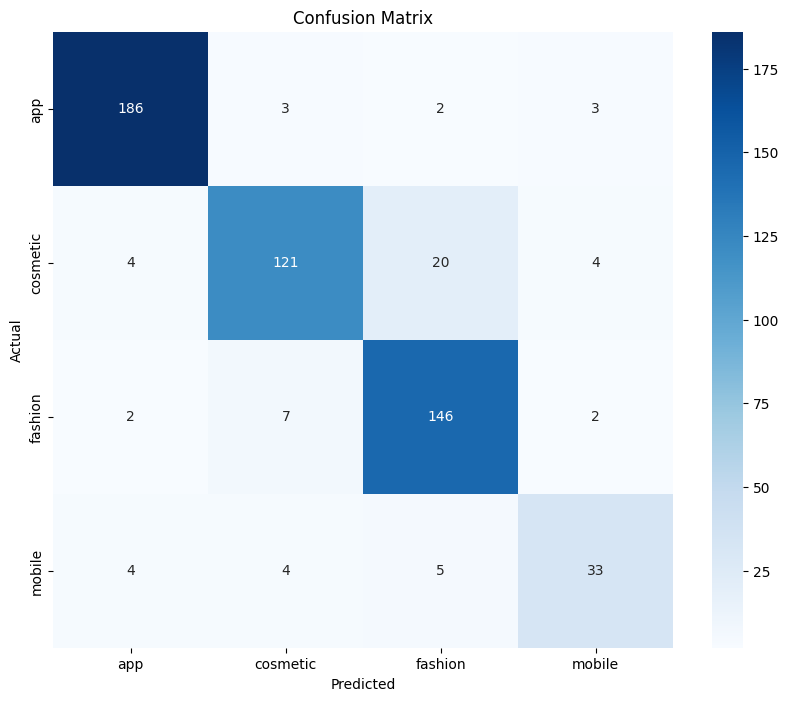

In [69]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

* Mô hình có Accuracym đạt mức 0.89. Mô hình phân loại cực tốt cho domain app với F1-score lên đến 0.95, theo sau là fashion và cosmetic với các chỉ số đều ở mức cao (trên 0.85). Tuy nhiên, domain mobile đang là điểm yếu nhất với F1-score chỉ đạt 0.75, nguyên nhân chính do lượng dữ liệu mẫu của nhóm này quá ít so với các nhóm còn lại, khiến mô hình chưa học được đầy đủ đặc trưng.

* Nhóm app là đạt kết quả cao nhất với 186 mẫu dự đoán đúng và tỷ lệ sai sót cực thấp. Tuy nhiên, ma trận cũng chỉ ra nhóm mobile do lượng dữ liệu ít, dẫn đến số lượng dự đoán đúng thấp hơn hẳn các nhóm khác. Đặc biệt, giữa cosmetic và fashion bị nhầm đến 20 mẫu, có thể do sự tương đồng về từ ngữ mô tả trong các bình luận thuộc hai lĩnh vực làm đẹp này, làm mô hình khó phân biệt.

* Để cải thiện mô hình, nên thu thập thêm dữ liệu cho nhóm mobile hoặc sử dụng kỹ thuật tăng cường dữ liệu để cân bằng dữ liệu.